# Spotify Usage Analysis
I want to find out who I listen to and what their basic background is.
[Medium Article](https://medium.com/@RareLoot/extracting-spotify-data-on-your-favourite-artist-via-python-d58bc92a4330)
[Examples](https://github.com/plamere/spotipy/tree/master/examples)

In [35]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import matplotlib.pyplot as plt
import numpy as np
import os
from client_secret import *

## Setup Spotify API connection

In [36]:
scope = "user-top-read"
redirect_uri = "http://localhost:8080"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

# Create security token
token = util.prompt_for_user_token(username,
                           scope,
                           client_id=client_id,
                           client_secret=client_secret,
                           redirect_uri=redirect_uri)

## Get my favourite artists

In [37]:
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    ranges = ['short_term', 'medium_term', 'long_term']
    for r in ranges:
        results = sp.current_user_top_artists(time_range=r, limit=50)

name=[]
popularity=[]
genres=[]
followers=[]

for artist in results['items']:
    if len(artist['genres']) > 0:
        name.append(artist['name'])
        popularity.append(artist['popularity'])
        followers.append(artist['followers']['total'])
        csv_genre=''
        for genre in artist['genres']:
            csv_genre+=genre+','
        genres.append(csv_genre)
        
artists = pd.DataFrame()
artists['name'] = name
artists['popularity'] = popularity
artists['followers'] = followers
artists['genre'] = genres
artists.head(5)

,name,popularity,followers,genre
0,Luke Kelly,52,47609,"banjo,celtic,irish banjo,irish country,irish f..."
1,The Weeknd,97,20838462,"canadian contemporary r&b,canadian pop,pop,"
2,The Beatles,90,16336613,"beatlesque,british invasion,classic rock,merse..."
3,Juice WRLD,96,9793200,"chicago rap,melodic rap,"
4,Hans Zimmer,80,1949558,"german soundtrack,soundtrack,"


### Plot Favourites

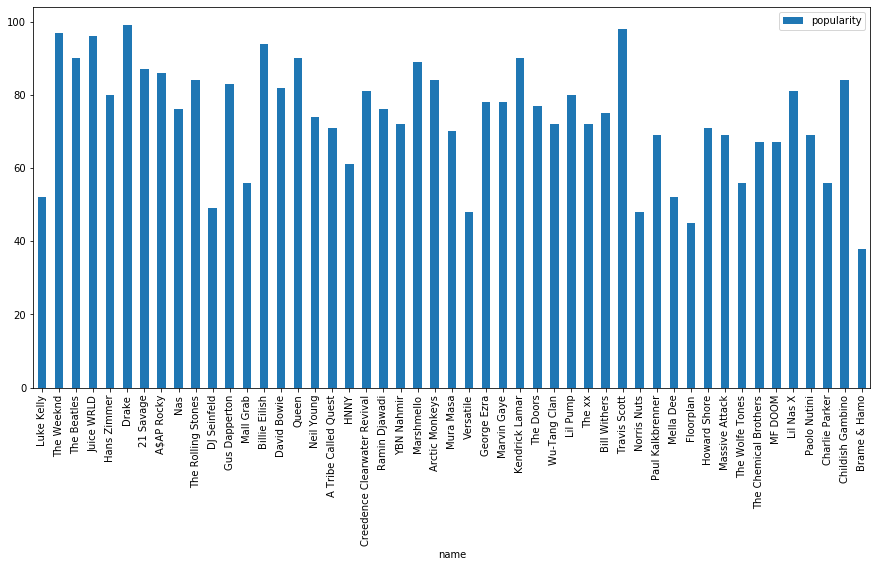

In [38]:
fig, ax = plt.subplots(figsize=(15,7))
artists.plot.bar(x ='name', y='popularity', ax=ax)

# Scrape Artist Ethnicity
https://ethnicelebs.com/

In [39]:
from bs4 import BeautifulSoup as bs4
import requests

## Scrape all paragraphs on page

In [40]:
def get_paragraph(artist_name):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
    base_url = "https://ethnicelebs.com/"
    
    # Parsed artists name
    parse_name = artist_name.replace(" ", "-")
    req = requests.get(base_url+parse_name, headers=headers)
    soup = bs4(req.content, "html.parser")

    # Find all <p> elements
    para = str(soup.find_all('p'))

    # Find range of string
    string_start = para.find("Ethnicity: ") + len("Ethnicity: ")
    string_end = para.find("</strong")
    race = para[string_start:string_end]
    
    if len(race) < 100:
#         return 'Artist: '+artist_name+'\nRace: '+ race
        return race


### Add races for each artist in df
Using BeautifulSoup is really slow.

In [ ]:
# Iterate over names and scrape
races = []
for artist in artists.name:
    races.append(get_paragraph(artist))

In [ ]:
# Convert to Pandas Series and add to df
artists_races = pd.Series( v for v in races )    
artists['race'] = artists_races
artists.head(5)

### Plot specific races
This plot has many specific races which gives a very messy graph. Grouping the ethnicities and removing the None values would be an improvement

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
artists.plot.bar(x ='race', y='popularity', ax=ax)

### Group ethnicities
- The artists not found from scraping are 'Unknown
- Some *assumptions* for the other races

In [ ]:
artists.race.loc[ artists.race.isnull() == True ] = 'Unknown'
artists.race.loc[ artists.race.str.contains('English|Irish|Jewish') == True ] = 'White'
artists.race.loc[ artists.race.str.contains('African|Black|Ethiopian') == True ] = 'Black'

### Plot grouped races
- count() prevents popularity playing a role in the numbers
- unstack() breaks the groupby into further groups (not sure)

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

# Group and plot
artists.groupby('race').count().unstack().popularity.plot.bar(ax=ax)

## Popularity Weighting System

In [ ]:
update trello, make plan

## Get more data